In [163]:
import itertools as it
import networkx as nx
import matplotlib.pyplot as plt
import re
from pprint import pprint
from collections import Counter



In [164]:
# Read the SQL DDLs
DDL_file = "./test_parser.sql"
with open(DDL_file) as fp:
    ddl = fp.read()


In [ ]:
 

results = parse_ddl(ddl)
print(f"#Tables: {len(results)}")
# pprint(results)

#Tables: 11


In [210]:
def get_multidigraph(results:list) -> nx.multidigraph:
    # Create a directed graph
    graph = nx.MultiDiGraph()

    # Add nodes (tables)
    tables = [result["table_name"] for result in results]
    graph.add_nodes_from(tables)

    # Add Edges (the referenced table of the foreign key is the sink of the edge)
    for result in results:
        if len(result['foreign_keys']) > 0:
            for foreign_key in result['foreign_keys']:
                edge_weight = 1
                for referenced_column in zip(foreign_key["columns"], foreign_key["referenced_columns"]):
                    # graph.add_edge(result['table_name'], foreign_key['referenced_table'],
                    #                relation=referenced_column)
                    relation_key = f"{referenced_column[0]}->{referenced_column[1]}"
                    # relation_key =  referenced_column
                    graph.add_edge(result['table_name'], foreign_key['referenced_table'],
                                key=relation_key, relation=relation_key, weight = edge_weight)
                    # edge_weight += 1

    return graph

def get_simple_digraph(graph:nx.multidigraph) -> nx.digraph:
    c = Counter(graph.edges())
    simple_digraph = nx.DiGraph()
    simple_digraph.add_nodes_from(graph)

    for u, v, d in graph.edges(data=True):
        # avoid repeating edges and self-loops
        if not simple_digraph.has_edge(u, v) and u != v:
            # simple_digraph.add_edge(u, v, weight=c[u, v])
            simple_digraph.add_edge(u, v, weight=1)


    # print(list(simple_digraph.edges(data=True)))
    return simple_digraph

graph = get_multidigraph(results)
print("Multi Di Graph")
pprint(str(graph.nodes()))
pprint(str(graph.edges(data=True)))
simple_graph = get_simple_digraph(graph)
print("Simple Di Graph")
pprint(str(simple_graph.nodes()))
pprint(str(simple_graph.edges(data=True)))
# Add edges (foreign key relationships)
# advisor.s_ID -> student.ID (ON DELETE CASCADE)
# graph.add_edge("`advisor`", "`student`", relation="advisor_ibfk_2: ON DELETE CASCADE")

# advisor.i_ID -> instructor.ID (ON DELETE SET NULL)
# graph.add_edge("`advisor`", "`instructor`", relation="advisor_ibfk_1: ON DELETE SET NULL")

# Visualize the graph
# pos = nx.shell_layout(graph)  # Layout for better visualization
# plt.figure(figsize=(10, 6))
# nx.draw(graph, pos, with_labels=True, node_size=2000, node_color="lightblue", font_size=10, font_weight="bold", arrowsize=15)
# edge_labels = nx.get_edge_attributes(graph, "relation")
# edge_weights = nx.get_edge_attributes(graph, "weight")

# nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=8)
# plt.title("Database Schema as a Graph", fontsize=16)
# plt.show()

Multi Di Graph
("['`advisor`', '`classroom`', '`course`', '`department`', '`instructor`', "
 "'`prereq`', '`section`', '`student`', '`takes`', '`teaches`', '`time_slot`']")
("[('`advisor`', '`instructor`', {'relation': '`i_ID`->`ID`', 'weight': 1}), "
 "('`advisor`', '`student`', {'relation': '`s_ID`->`ID`', 'weight': 1}), "
 "('`course`', '`department`', {'relation': '`dept_name`->`dept_name`', "
 "'weight': 1}), ('`instructor`', '`department`', {'relation': "
 "'`dept_name`->`dept_name`', 'weight': 1}), ('`prereq`', '`course`', "
 "{'relation': '`course_id`->`course_id`', 'weight': 1}), ('`prereq`', "
 "'`course`', {'relation': '`prereq_id`->`course_id`', 'weight': 1}), "
 "('`section`', '`course`', {'relation': '`course_id`->`course_id`', 'weight': "
 "1}), ('`section`', '`classroom`', {'relation': '`building`->`building`', "
 "'weight': 1}), ('`section`', '`classroom`', {'relation': "
 "'`room_number`->`room_number`', 'weight': 1}), ('`section`', '`time_slot`', "
 "{'relation': '`t

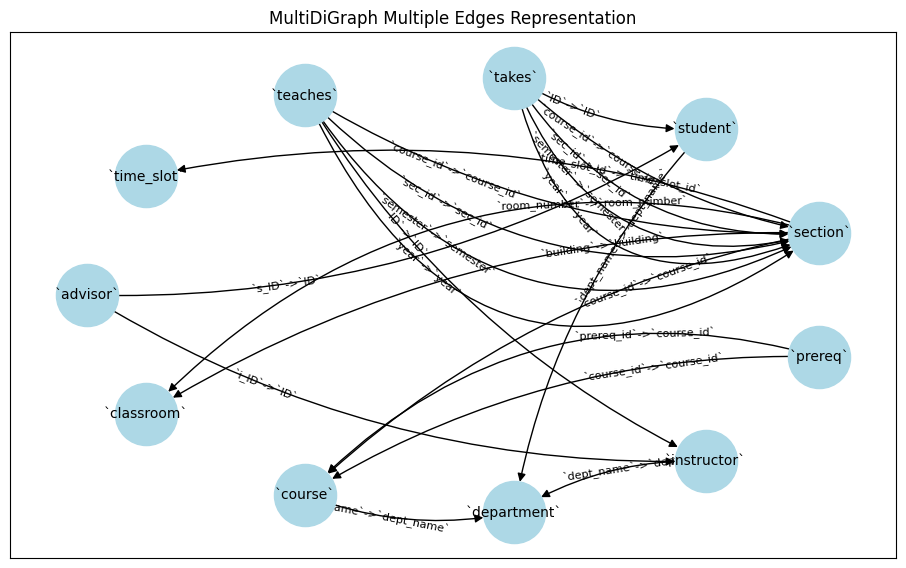

In [167]:
def draw_labeled_multigraph(graph):
    """
    Length of connectionstyle must be at least that of a maximum number of edges
    between pair of nodes. This number is maximum one-sided connections
    for directed graph and maximum total connections for undirected graph.
    """
    fig, ax = plt.subplots(1, 1)

    fig.tight_layout()
    fig.set_size_inches(10, 6)
    # Works with arc3 and angle3 connectionstyles
    node_size = 2000
    attr_name = "relation"
    connectionstyle = [f"arc3,rad={r}" for r in it.accumulate([0.15] * 20)]
    # connectionstyle = [f"angle3,angleA={r}" for r in it.accumulate([30] * 4)]

    pos = nx.shell_layout(graph)
    nx.draw_networkx_nodes(graph, pos, node_size=node_size,
                           node_color="lightblue", ax=ax)
    nx.draw_networkx_labels(graph, pos, font_size=10, ax=ax)
    nx.draw_networkx_edges(graph, pos,
                            arrows=True,
                            arrowsize=12,
                            node_size=node_size,
                            connectionstyle=connectionstyle,
                            edge_color="black",
                            ax=ax
                            )
    edge_labels = {
        tuple(edge): f"{attrs[attr_name]}"
        for *edge, attrs in graph.edges(keys=True, data=True)
    }
    nx.draw_networkx_edge_labels(
        graph,
        pos,
        edge_labels,
        connectionstyle=connectionstyle,
        label_pos=0.3,
        font_color="black",
        font_size=8,
        bbox={"alpha": 0},
        ax=ax,
    )
    ax.set_title("MultiDiGraph Multiple Edges Representation")

    plt.show()

draw_labeled_multigraph(graph)

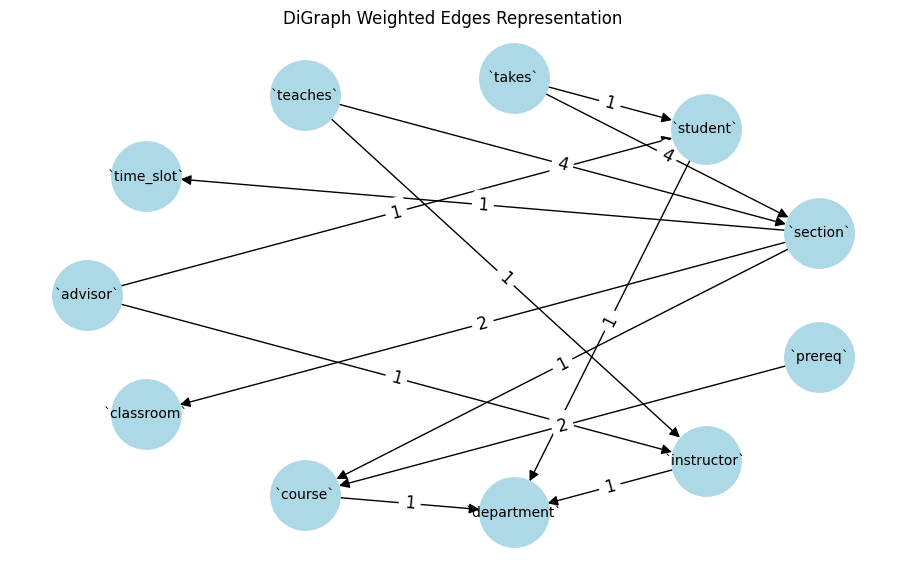

In [187]:
def draw_weighted_graph(graph: nx.MultiDiGraph):
    """
    Length of connectionstyle must be at least that of a maximum number of edges
    between pair of nodes. This number is maximum one-sided connections
    for directed graph and maximum total connections for undirected graph.
    """
    fig, ax = plt.subplots(1, 1)

    fig.tight_layout()
    fig.set_size_inches(10, 6)
    # Works with arc3 and angle3 connectionstyles
    node_size = 2500

    if type(graph) == nx.MultiDiGraph:
        c = Counter(graph.edges())
        simple_digraph = nx.DiGraph()
        simple_digraph.add_nodes_from(graph)

        for u, v, d in graph.edges(data=True):
            # avoid repeating edges and self-loops
            if not simple_digraph.has_edge(u, v) and u != v:
                simple_digraph.add_edge(u, v, weight=c[u, v])
    else:
        simple_digraph = graph

    pos = nx.shell_layout(simple_digraph)
    nx.draw(simple_digraph, pos, with_labels=True, node_size=node_size,
            node_color="lightblue", font_size=10, 
            arrowsize=15, 
            ax=ax)
    edge_labels = nx.get_edge_attributes(simple_digraph, "weight")

    nx.draw_networkx_edge_labels(simple_digraph, pos, edge_labels=edge_labels, font_size=12, ax=ax)
    ax.set_title("DiGraph Weighted Edges Representation")
    plt.show()


draw_weighted_graph(graph)

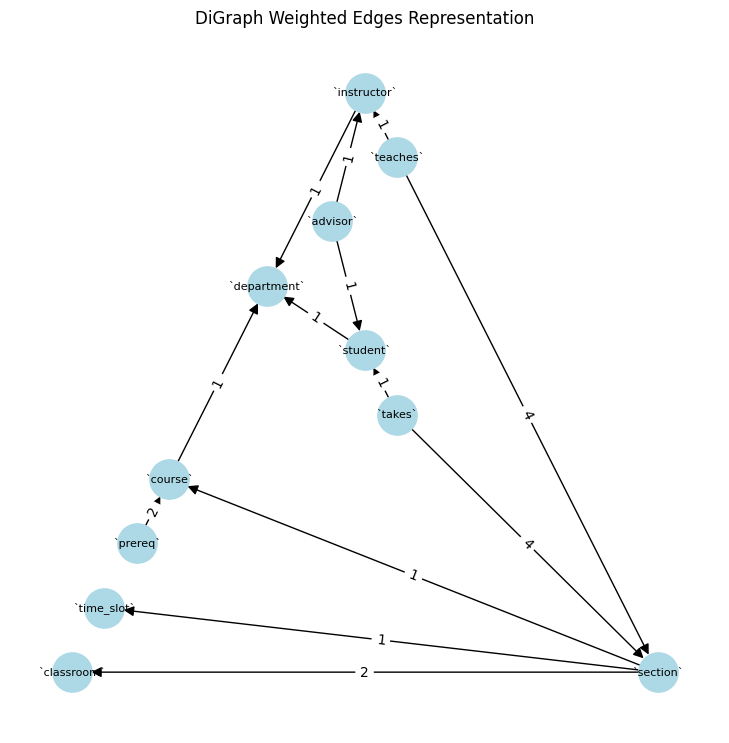

In [188]:
def draw_planar_graph(graph: nx.MultiDiGraph):

    fig, ax = plt.subplots(1, 1)

    fig.tight_layout()
    fig.set_size_inches(8, 8)
    node_size = 800

    if type(graph) == nx.MultiDiGraph:
        c = Counter(graph.edges())
        simple_digraph = nx.DiGraph()
        simple_digraph.add_nodes_from(graph)

        for u, v, d in graph.edges(data=True):
            # avoid repeating edges and self-loops
            if not simple_digraph.has_edge(u, v) and u != v:
                simple_digraph.add_edge(u, v, weight=c[u, v])
    else:
        simple_digraph = graph

    pos = nx.planar_layout(simple_digraph)
    nx.draw(simple_digraph, pos, with_labels=True, node_size=node_size,
            node_color="lightblue", font_size=8, 
            arrowsize=15, 
            ax=ax)
    edge_labels = nx.get_edge_attributes(simple_digraph, "weight")

    nx.draw_networkx_edge_labels(simple_digraph, pos, 
                                 edge_labels=edge_labels, font_size=10, ax=ax)
    ax.set_title("DiGraph Weighted Edges Representation")
    plt.show()


draw_planar_graph(graph)

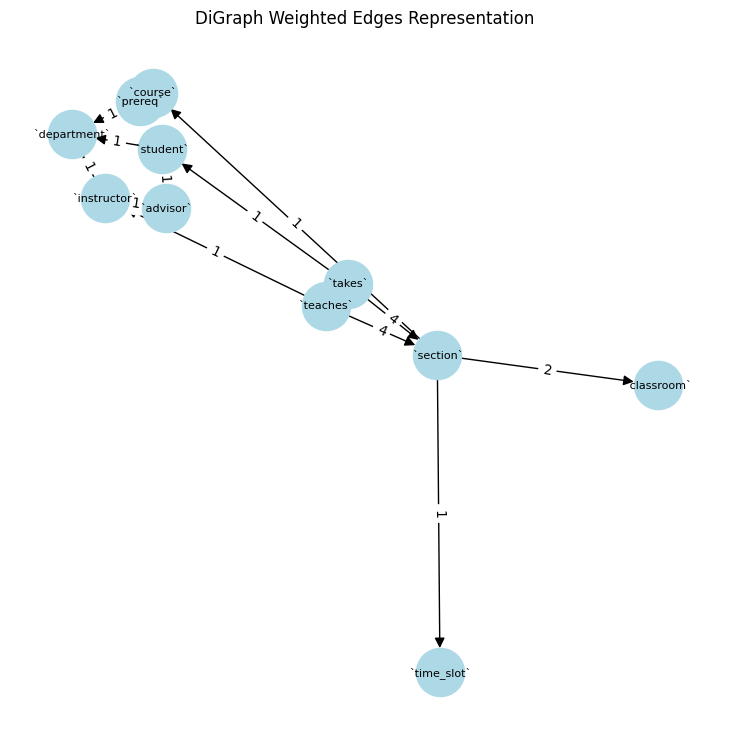

In [189]:
def draw_spring_graph(graph: nx.MultiDiGraph):

    fig, ax = plt.subplots(1, 1)

    fig.tight_layout()
    fig.set_size_inches(8, 8)
    node_size = 1200

    if type(graph) == nx.MultiDiGraph:
        c = Counter(graph.edges())
        simple_digraph = nx.DiGraph()
        simple_digraph.add_nodes_from(graph)

        for u, v, d in graph.edges(data=True):
            # avoid repeating edges and self-loops
            if not simple_digraph.has_edge(u, v) and u != v:
                simple_digraph.add_edge(u, v, weight=c[u, v])
    else:
        simple_digraph = graph

    # print(list(simple_digraph.edges(data=True)))

    pos = nx.spring_layout(simple_digraph)
    nx.draw(simple_digraph, pos, with_labels=True, node_size=node_size,
            node_color="lightblue", font_size=8, 
            arrowsize=15, 
            ax=ax)
    edge_labels = nx.get_edge_attributes(simple_digraph, "weight")

    nx.draw_networkx_edge_labels(simple_digraph, pos, 
                                 edge_labels=edge_labels, font_size=10, ax=ax)
    ax.set_title("DiGraph Weighted Edges Representation")
    plt.show()


draw_spring_graph(graph)

[{'`advisor`', '`department`', '`student`', '`instructor`'},
 {'`prereq`', '`course`'},
 {'`teaches`', '`takes`', '`classroom`', '`section`', '`time_slot`'}]


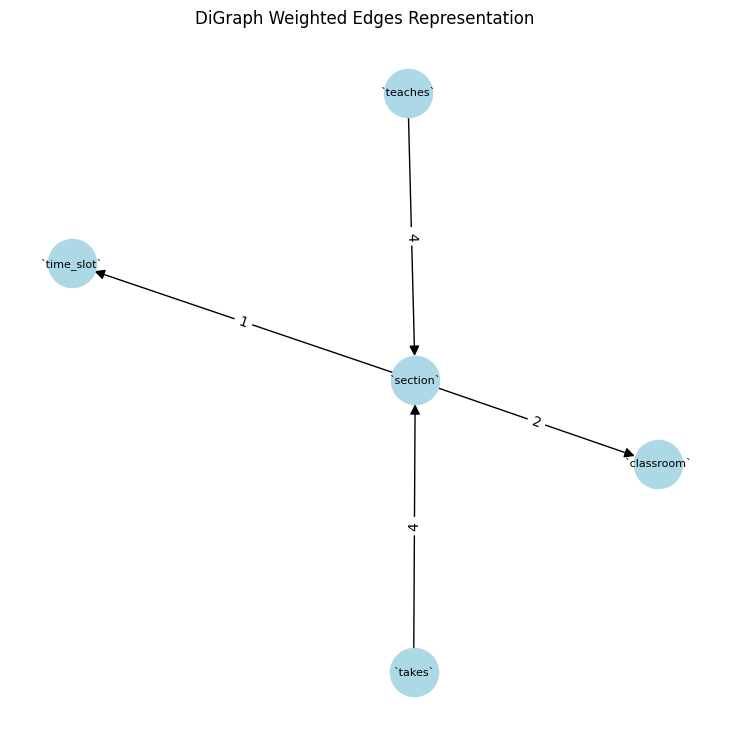

In [206]:
communities = nx.community.louvain_communities(simple_graph, seed = 0)
pprint(communities)
sub_graph = simple_graph.subgraph(communities[2])


draw_spring_graph(sub_graph)

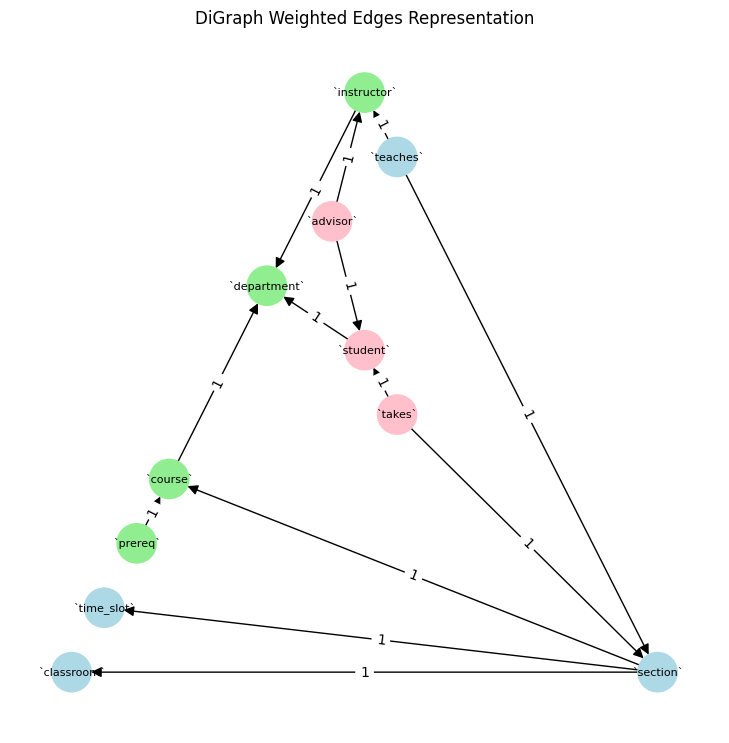

In [213]:
def draw_colored_planar_graph(graph: nx.MultiDiGraph, communities:list):
    if len(communities) > 3:
        raise Exception("Communities longer than 3 not supported!")
    
    fig, ax = plt.subplots(1, 1)

    fig.tight_layout()
    fig.set_size_inches(8, 8)
    node_size = 800

    if type(graph) == nx.MultiDiGraph:
        c = Counter(graph.edges())
        simple_digraph = nx.DiGraph()
        simple_digraph.add_nodes_from(graph)

        for u, v, d in graph.edges(data=True):
            # avoid repeating edges and self-loops
            if not simple_digraph.has_edge(u, v) and u != v:
                # simple_digraph.add_edge(u, v, weight=c[u, v]
                simple_digraph.add_edge(u, v, weight=1)
                
    else:
        simple_digraph = graph

    nodes = simple_digraph.nodes()
    colors = ["pink", "lightgreen", "lightblue"]
    node_colors_dict = {}
    for entry in zip(colors, communities):
        for node in entry[1]:
            node_colors_dict[node] = entry[0]
    node_colors = [node_colors_dict[node] for node in nodes]

    pos = nx.planar_layout(simple_digraph)
    nx.draw(simple_digraph, pos, with_labels=True, node_size=node_size,
            node_color=node_colors, font_size=8, 
            arrowsize=15, 
            ax=ax)
    edge_labels = nx.get_edge_attributes(simple_digraph, "weight")

    nx.draw_networkx_edge_labels(simple_digraph, pos, 
                                 edge_labels=edge_labels, font_size=10, ax=ax)
    ax.set_title("DiGraph Weighted Edges Representation")
    plt.show()

communities = nx.community.louvain_communities(simple_graph, seed = 0)

draw_colored_planar_graph(graph, communities)